# Constraint Diagram

Auto-generated from `h3000_M0.3_R1000km_PL1000kg.ini` by `app/main.py`.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ADRpy import unitconversions as co
from ADRpy import constraintanalysis as ca
from ADRpy import atmospheres as at

designbrief = {'rwyelevation_m': 0.0,
 'groundrun_m': 400.0,
 'stloadfactor': 1.5,
 'turnalt_m': 3000.0,
 'turnspeed_ktas': 160.0,
 'climbalt_m': 3000.0,
 'climbspeed_kias': 160.0,
 'climbrate_fpm': 1300.0,
 'cruisealt_m': 3000.0,
 'cruisespeed_ktas': 192.0,
 'cruisethrustfact': 1.0,
 'servceil_m': 6000.0,
 'secclimbspd_kias': 110.0,
 'vstallclean_kcas': 100.0}
designatm = at.Atmosphere()
TOW_kg = 6459.261

designdefinition = {'aspectratio': 9.0,
 'sweep_le_deg': 2.0,
 'sweep_mt_deg': 0.0,
 'weightfractions': {'turn': 1.0, 'climb': 1.0, 'cruise': 1.0, 'servceil': 1.0},
 'weight_n': co.kg2n(TOW_kg)}

designperformance = {'CDTO': 0.0414,
 'CLTO': 1.2,
 'CLmaxTO': 2.15,
 'CLmaxclean': 1.45,
 'mu_R': 0.02,
 'CDminclean': 0.0254,
 'etaprop': {'take-off': 0.7,
             'climb': 0.8,
             'cruise': 0.85,
             'turn': 0.85,
             'servceil': 0.8}}

designpropulsion = 'electric'

concept = ca.AircraftConcept(designbrief, designdefinition, designperformance, designatm, designpropulsion)


## Quick Constraint Diagram Plots


In [2]:
ws_min_pa = 1900.000
ws_max_pa = 2600.000
ws_step_pa = 50.000

ws_step_plot_pa = max(ws_step_pa / 10.0, 1.0)
wslist_pa = np.arange(ws_min_pa, ws_max_pa + 0.5 * ws_step_plot_pa, ws_step_plot_pa)
if wslist_pa.size < 2:
    wslist_pa = np.array([ws_min_pa, ws_max_pa], dtype=float)

preq_quick = concept.powerrequired(wslist_pa, tow_kg=TOW_kg, feasibleonly=False, map2sl=True)
twreq_quick = concept.twrequired(wslist_pa, feasibleonly=False, map2sl=True)
preq_quick_kw_combined = np.asarray(co.hp2kw(preq_quick['combined']), dtype=float)
y_lim_power_kw = float(np.nanmax(preq_quick_kw_combined) * 2.0)
y_lim_tw = float(np.nanmax(twreq_quick['combined']) * 2.0)

ws_initial_pa = 2830.240000
ws_converged_pa = 2162.320370
p_w_initial_climb_kw_per_kg = 0.11390000
p_w_converged_climb_kw_per_kg = 0.24230797

g0_mps2 = 9.80665
wslist_kg_per_m2 = wslist_pa / g0_mps2
ws_initial_kg_per_m2 = ws_initial_pa / g0_mps2
ws_converged_kg_per_m2 = ws_converged_pa / g0_mps2

pwreq_quick_kw_per_kg = preq_quick_kw_combined / float(TOW_kg)
y_lim_pw_kw_per_kg = float(np.nanmax(pwreq_quick_kw_per_kg) * 2.0)
twreq_quick_combined = np.asarray(twreq_quick['combined'], dtype=float)

pw_comb_initial_kw_per_kg = float(np.interp(ws_initial_pa, wslist_pa, pwreq_quick_kw_per_kg))
pw_comb_converged_kw_per_kg = float(np.interp(ws_converged_pa, wslist_pa, pwreq_quick_kw_per_kg))
tw_comb_initial = float(np.interp(ws_initial_pa, wslist_pa, twreq_quick_combined))
tw_comb_converged = float(np.interp(ws_converged_pa, wslist_pa, twreq_quick_combined))

try:
    wsmax_cleanstall_pa = float(concept.wsmaxcleanstall_pa())
except Exception:
    wsmax_cleanstall_pa = np.nan
valid_stall = np.isfinite(wslist_pa)
if np.isfinite(wsmax_cleanstall_pa):
    valid_stall &= wslist_pa <= wsmax_cleanstall_pa

def _curve_min(curve_key):
    if curve_key not in preq_quick:
        return np.nan, np.nan
    curve_kwkg = np.asarray(co.hp2kw(preq_quick[curve_key]), dtype=float) / float(TOW_kg)
    valid = np.isfinite(curve_kwkg) & valid_stall
    idxs = np.where(valid)[0]
    if idxs.size == 0:
        return np.nan, np.nan
    i_min = idxs[int(np.nanargmin(curve_kwkg[idxs]))]
    return float(wslist_pa[i_min]), float(curve_kwkg[i_min])

curve_keys = {'combined': 'combined', 'takeoff': 'take-off', 'climb': 'climb', 'cruise': 'cruise'}
print('--- Minimum ADRpy P/W points over scanned W/S ---')
for label, curve_key in curve_keys.items():
    ws_min_curve_pa, pw_min_curve_kwkg = _curve_min(curve_key)
    if np.isfinite(ws_min_curve_pa):
        print(
            f"{label:>8}: curve='{curve_key}', W/S={ws_min_curve_pa:.1f} Pa "
            f"({ws_min_curve_pa / g0_mps2:.2f} kg/m^2), P/W={pw_min_curve_kwkg:.5f} kW/kg"
        )
    else:
        print(f"{label:>8}: curve='{curve_key}', no finite/stall-feasible points in scan window")

print('--- Marked design points (INI vs converged) ---')
print(f"INI input:      W/S={ws_initial_pa:.1f} Pa | P/W(climb,input)={p_w_initial_climb_kw_per_kg:.5f} kW/kg | "
      f"P/W(combined@W/S)={pw_comb_initial_kw_per_kg:.5f} kW/kg | T/W(combined@W/S)={tw_comb_initial:.5f}")
print(f"Converged run:  W/S={ws_converged_pa:.1f} Pa | P/W(climb,conv)={p_w_converged_climb_kw_per_kg:.5f} kW/kg | "
      f"P/W(combined@W/S)={pw_comb_converged_kw_per_kg:.5f} kW/kg | T/W(combined@W/S)={tw_comb_converged:.5f}")



--- Minimum ADRpy P/W points over scanned W/S ---
combined: curve='combined', W/S=2170.0 Pa (221.28 kg/m^2), P/W=0.17621 kW/kg
 takeoff: curve='take-off', W/S=1900.0 Pa (193.75 kg/m^2), P/W=0.14621 kW/kg
   climb: curve='climb', W/S=2350.0 Pa (239.63 kg/m^2), P/W=0.17396 kW/kg
  cruise: curve='cruise', W/S=2350.0 Pa (239.63 kg/m^2), P/W=0.07975 kW/kg
--- Marked design points (INI vs converged) ---
INI input:      W/S=2830.2 Pa | P/W(climb,input)=0.11390 kW/kg | P/W(combined@W/S)=0.22717 kW/kg | T/W(combined@W/S)=0.33176
Converged run:  W/S=2162.3 Pa | P/W(climb,conv)=0.24231 kW/kg | P/W(combined@W/S)=0.17632 kW/kg | T/W(combined@W/S)=0.28050


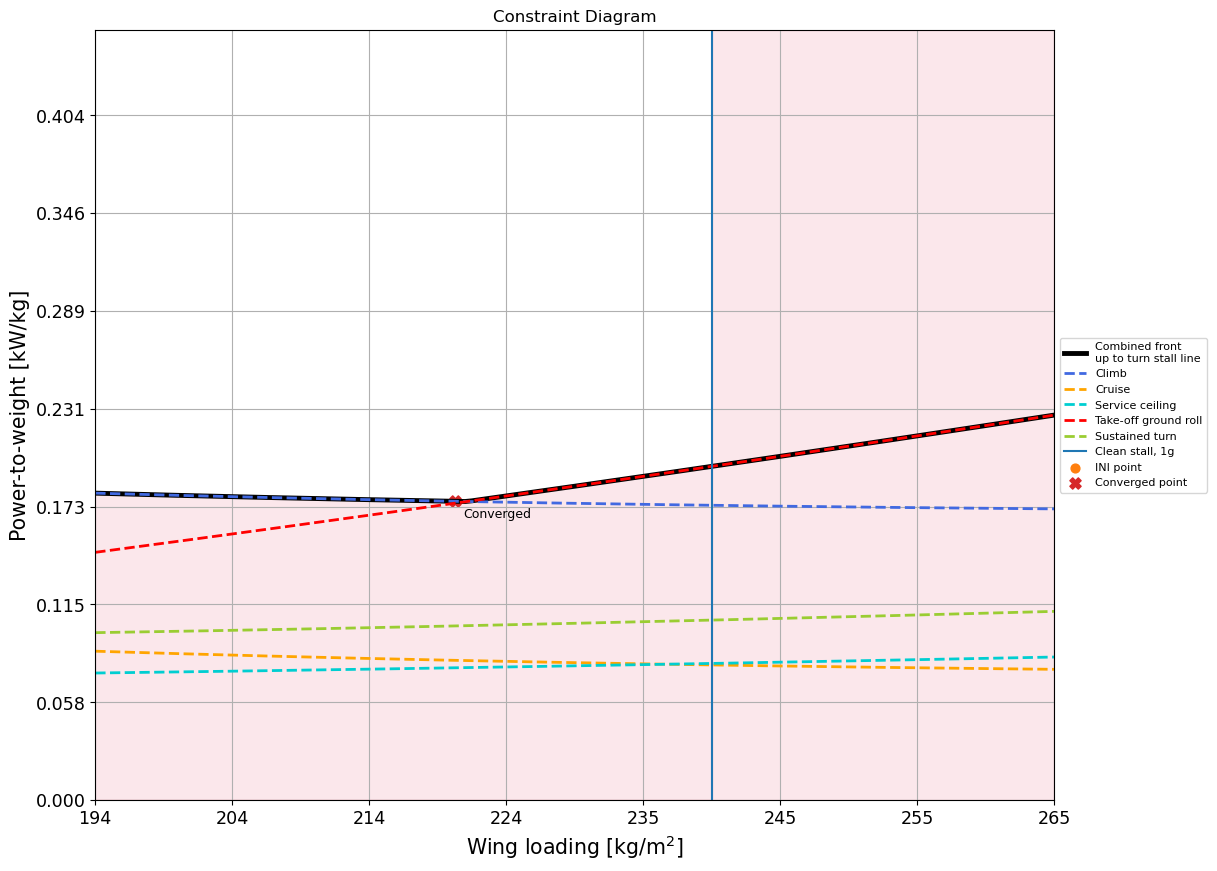

In [3]:
from matplotlib.ticker import FuncFormatter

y_lim_p_hp = float(co.kw2hp(y_lim_pw_kw_per_kg * TOW_kg))
_show_orig = plt.show
_close_orig = plt.close
try:
    # Keep ADRpy's original combined-plot styling figure alive for post-formatting.
    plt.show = lambda *args, **kwargs: None
    plt.close = lambda *args, **kwargs: None
    _ = concept.propulsionsensitivity_monothetic(
        wingloading_pa=wslist_pa,
        show='combined',
        y_var='p_hp',
        x_var='ws_pa',
        y_lim=y_lim_p_hp,
    )
finally:
    plt.show = _show_orig
    plt.close = _close_orig
ax = plt.gca()
p_hp_initial_marker = float(co.kw2hp(pw_comb_initial_kw_per_kg * TOW_kg))
p_hp_converged_marker = float(co.kw2hp(pw_comb_converged_kw_per_kg * TOW_kg))
ax.scatter([ws_initial_pa], [p_hp_initial_marker], color='tab:orange', marker='o', s=40, label='INI point')
ax.scatter([ws_converged_pa], [p_hp_converged_marker], color='tab:red', marker='X', s=65, label='Converged point')
ax.annotate('INI', (ws_initial_pa, p_hp_initial_marker), textcoords='offset points', xytext=(6, 8), fontsize=9)
ax.annotate('Converged', (ws_converged_pa, p_hp_converged_marker), textcoords='offset points', xytext=(6, -12), fontsize=9)
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x / g0_mps2:.0f}"))
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f"{co.hp2kw(y) / TOW_kg:.3f}"))
ax.set_xlabel('Wing loading [kg/m$^2$]')
ax.set_ylabel('Power-to-weight [kW/kg]')
ax.set_title('Constraint Diagram')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=8)
plt.show()


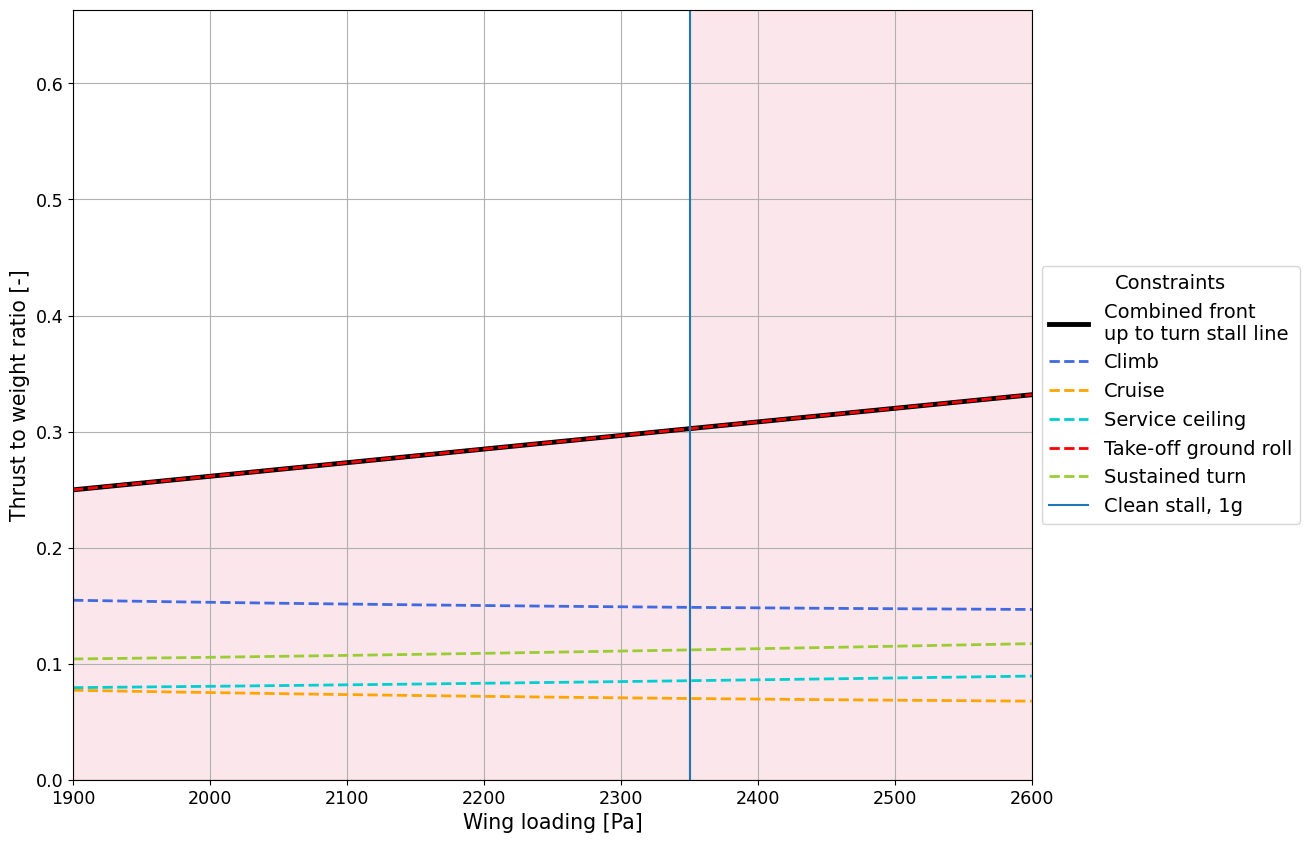

In [4]:
_ = concept.propulsionsensitivity_monothetic(
    wingloading_pa=wslist_pa,
    show='combined',
    y_var='tw',
    x_var='ws_pa',
    y_lim=y_lim_tw,
)


## Flexible Constraint Plot


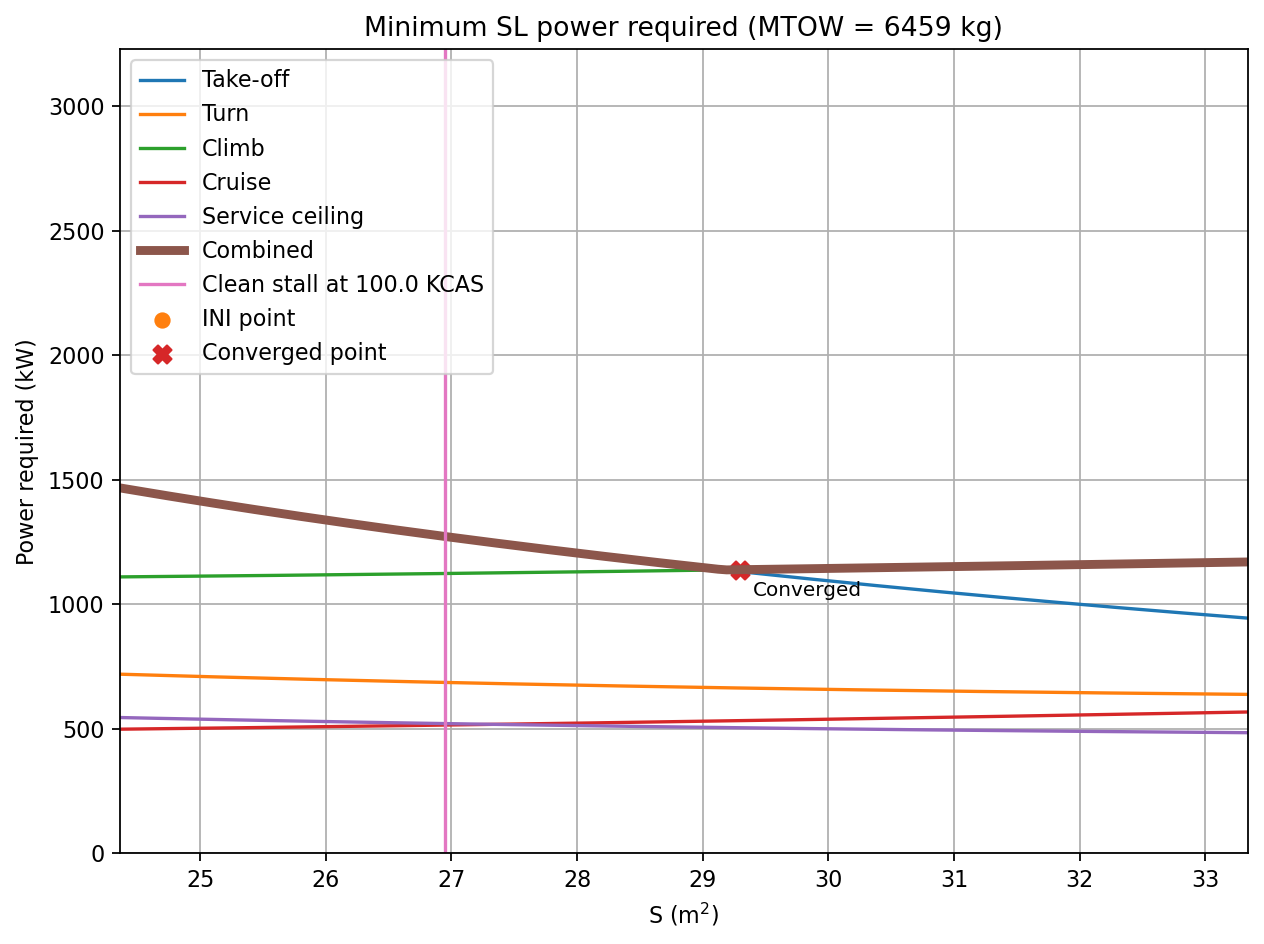

In [5]:
preq = concept.powerrequired(wslist_pa, tow_kg=TOW_kg, feasibleonly=False, map2sl=True)
preq_kw = {k: np.asarray(co.hp2kw(v), dtype=float) for k, v in preq.items()}
Smin_m2 = concept.smincleanstall_m2(TOW_kg)
wingarea_m2 = co.kg2n(TOW_kg) / wslist_pa

s_initial_m2 = float(co.kg2n(TOW_kg) / ws_initial_pa)
s_converged_m2 = float(co.kg2n(TOW_kg) / ws_converged_pa)
p_kw_initial = float(np.interp(ws_initial_pa, wslist_pa, preq_kw['combined']))
p_kw_converged = float(np.interp(ws_converged_pa, wslist_pa, preq_kw['combined']))

plt.rcParams['figure.figsize'] = [8, 6]
plt.rcParams['figure.dpi'] = 160
plt.plot(wingarea_m2, preq_kw['take-off'], label='Take-off')
plt.plot(wingarea_m2, preq_kw['turn'], label='Turn')
plt.plot(wingarea_m2, preq_kw['climb'], label='Climb')
plt.plot(wingarea_m2, preq_kw['cruise'], label='Cruise')
plt.plot(wingarea_m2, preq_kw['servceil'], label='Service ceiling')
combplot = plt.plot(wingarea_m2, preq_kw['combined'], label='Combined')
plt.setp(combplot, linewidth=4)
y_max = float(np.nanmax(preq_kw['combined']) * 2.2)
stall_label = f"Clean stall at {designbrief['vstallclean_kcas']} KCAS"
plt.plot([Smin_m2, Smin_m2], [0, y_max], label=stall_label)
plt.scatter([s_initial_m2], [p_kw_initial], color='tab:orange', marker='o', s=40, label='INI point')
plt.scatter([s_converged_m2], [p_kw_converged], color='tab:red', marker='X', s=65, label='Converged point')
plt.annotate('INI', (s_initial_m2, p_kw_initial), textcoords='offset points', xytext=(6, 8), fontsize=9)
plt.annotate('Converged', (s_converged_m2, p_kw_converged), textcoords='offset points', xytext=(6, -12), fontsize=9)
plt.legend(loc='upper left')
plt.ylabel('Power required (kW)')
plt.xlabel('S (m$^2$)')
plt.title(f"Minimum SL power required (MTOW = {round(TOW_kg)} kg)")
plt.xlim(min(wingarea_m2), max(wingarea_m2))
plt.ylim(0, y_max)
plt.grid(True)
plt.tight_layout()
plt.savefig('Constraint_Diagram.png', dpi=200)
plt.show()


## INI vs Converged Markers (P/W and T/W)


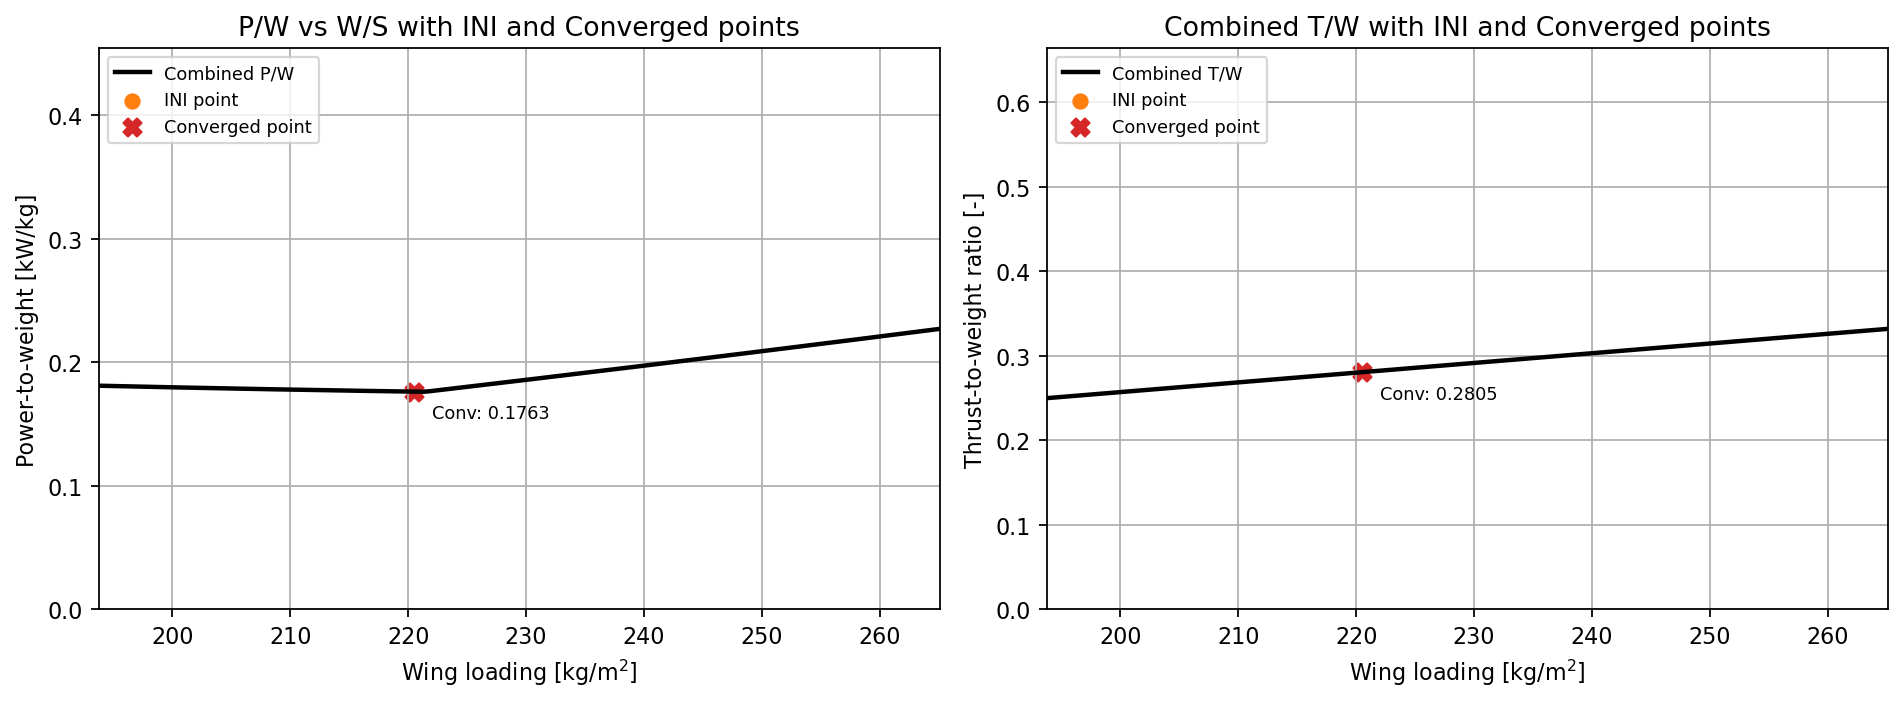

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4.5), dpi=160)

ax[0].plot(wslist_kg_per_m2, pwreq_quick_kw_per_kg, color='black', linewidth=2.0, label='Combined P/W')
ax[0].scatter([ws_initial_kg_per_m2], [pw_comb_initial_kw_per_kg], color='tab:orange', marker='o', s=40, label='INI point')
ax[0].scatter([ws_converged_kg_per_m2], [pw_comb_converged_kw_per_kg], color='tab:red', marker='X', s=65, label='Converged point')
ax[0].annotate(f"INI: {pw_comb_initial_kw_per_kg:.4f}", (ws_initial_kg_per_m2, pw_comb_initial_kw_per_kg),
               textcoords='offset points', xytext=(8, 8), fontsize=8)
ax[0].annotate(f"Conv: {pw_comb_converged_kw_per_kg:.4f}", (ws_converged_kg_per_m2, pw_comb_converged_kw_per_kg),
               textcoords='offset points', xytext=(8, -12), fontsize=8)
ax[0].set_xlim(float(np.min(wslist_kg_per_m2)), float(np.max(wslist_kg_per_m2)))
ax[0].set_ylim(0.0, float(np.nanmax(pwreq_quick_kw_per_kg) * 2.0))
ax[0].set_xlabel('Wing loading [kg/m$^2$]')
ax[0].set_ylabel('Power-to-weight [kW/kg]')
ax[0].set_title('P/W vs W/S with INI and Converged points')
ax[0].grid(True)
ax[0].legend(loc='upper left', fontsize=8)

ax[1].plot(wslist_kg_per_m2, twreq_quick_combined, color='black', linewidth=2.0, label='Combined T/W')
ax[1].scatter([ws_initial_kg_per_m2], [tw_comb_initial], color='tab:orange', marker='o', s=40, label='INI point')
ax[1].scatter([ws_converged_kg_per_m2], [tw_comb_converged], color='tab:red', marker='X', s=65, label='Converged point')
ax[1].annotate(f"INI: {tw_comb_initial:.4f}", (ws_initial_kg_per_m2, tw_comb_initial),
               textcoords='offset points', xytext=(8, 8), fontsize=8)
ax[1].annotate(f"Conv: {tw_comb_converged:.4f}", (ws_converged_kg_per_m2, tw_comb_converged),
               textcoords='offset points', xytext=(8, -12), fontsize=8)
ax[1].set_xlim(float(np.min(wslist_kg_per_m2)), float(np.max(wslist_kg_per_m2)))
ax[1].set_ylim(0.0, float(np.nanmax(twreq_quick_combined) * 2.0))
ax[1].set_xlabel('Wing loading [kg/m$^2$]')
ax[1].set_ylabel('Thrust-to-weight ratio [-]')
ax[1].set_title('Combined T/W with INI and Converged points')
ax[1].grid(True)
ax[1].legend(loc='upper left', fontsize=8)

plt.tight_layout()
plt.show()


## Sensitivity Plots

This section mirrors the sensitivity plotting workflow from `constraint_example.ipynb` using +/-5% ranges around this INI case values.


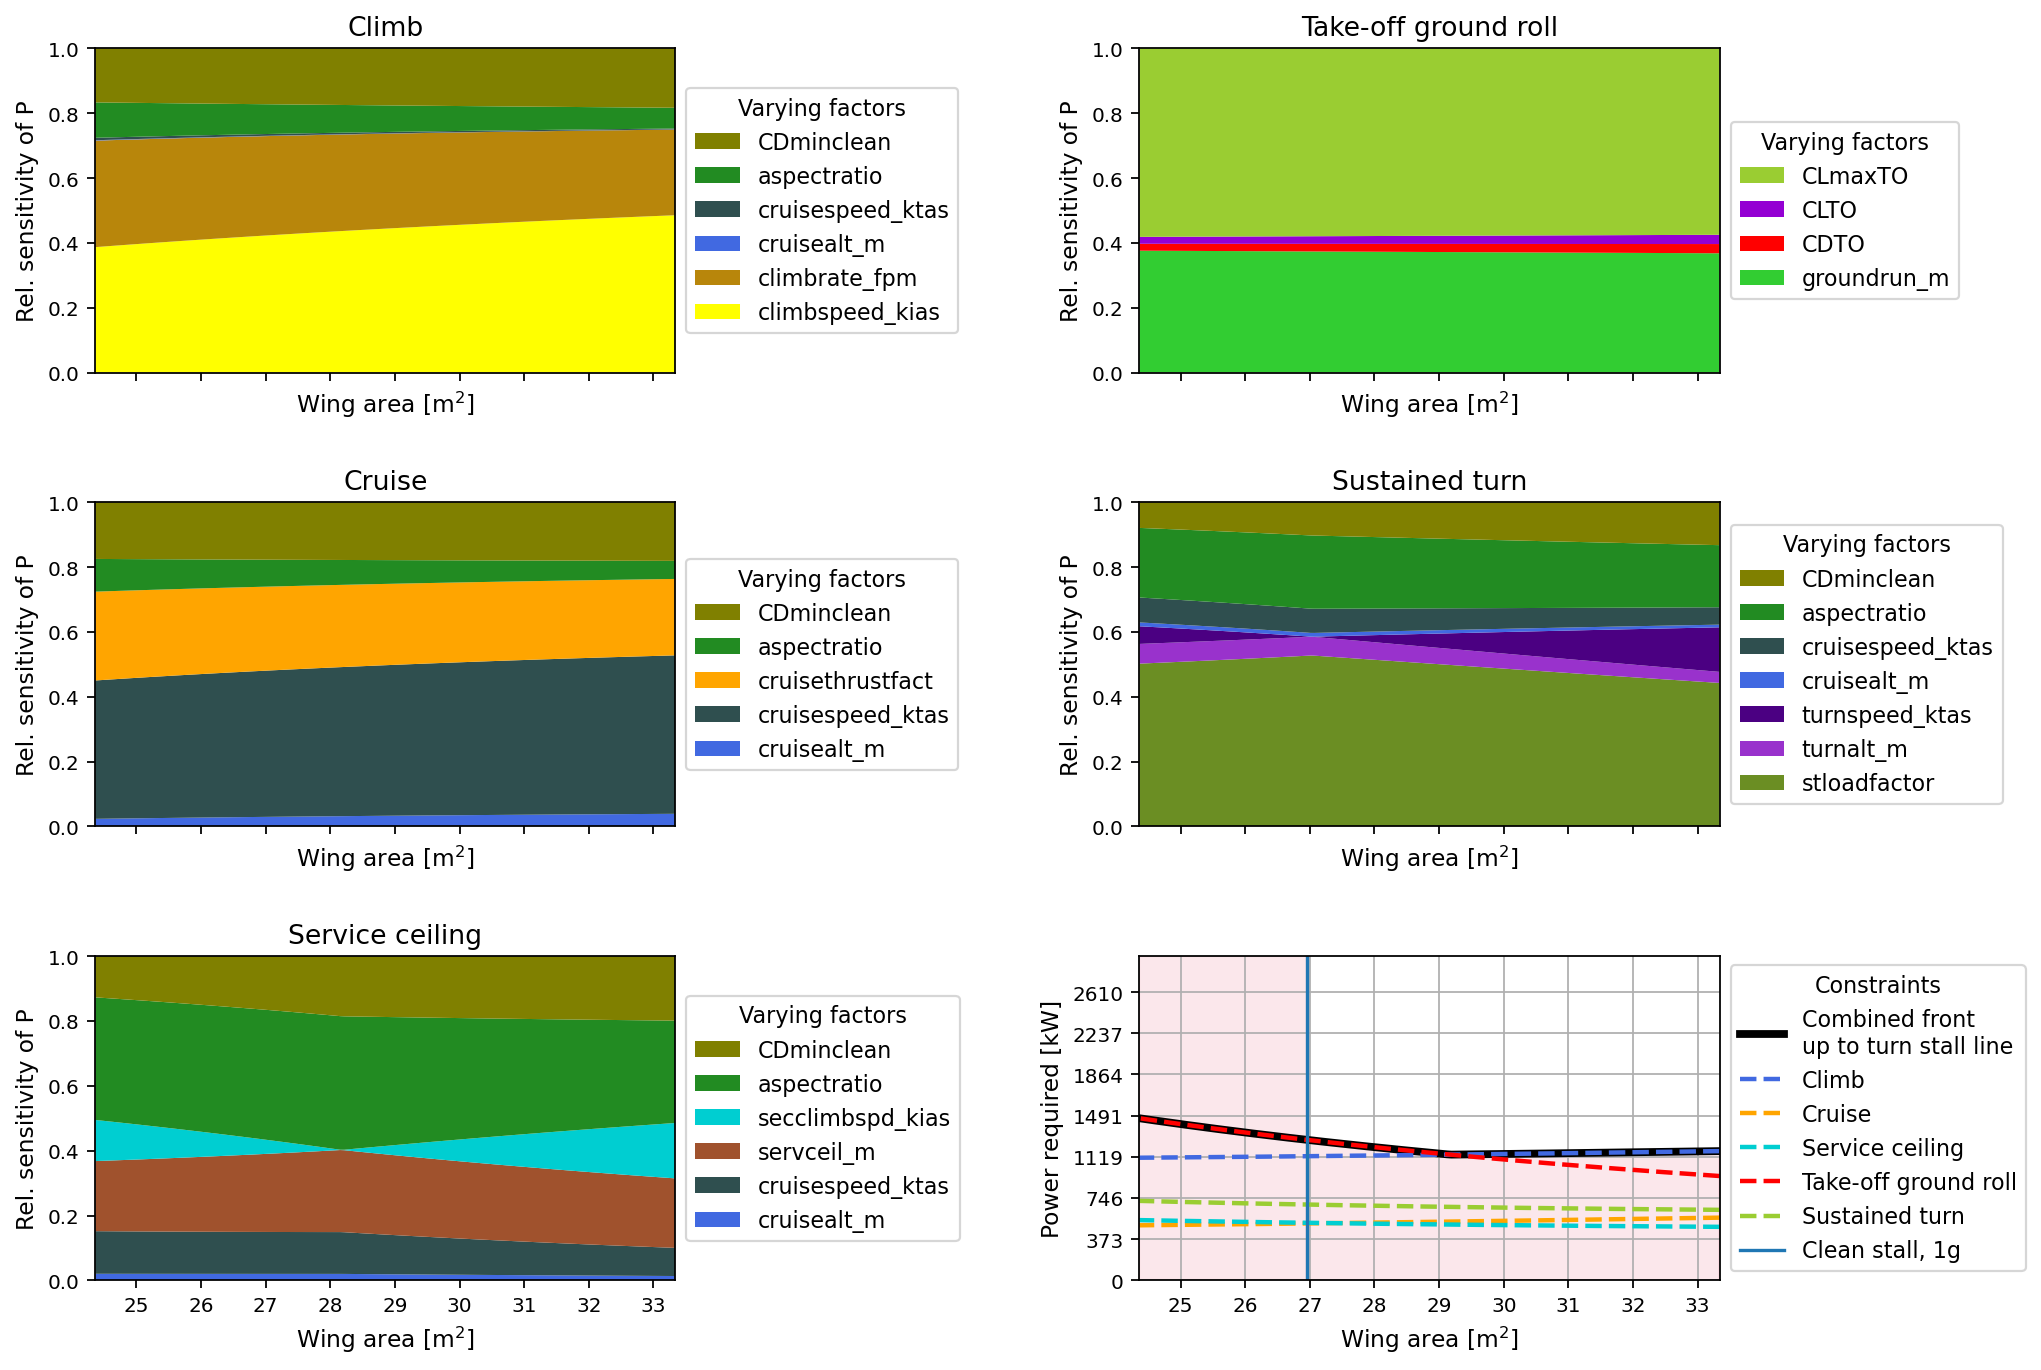

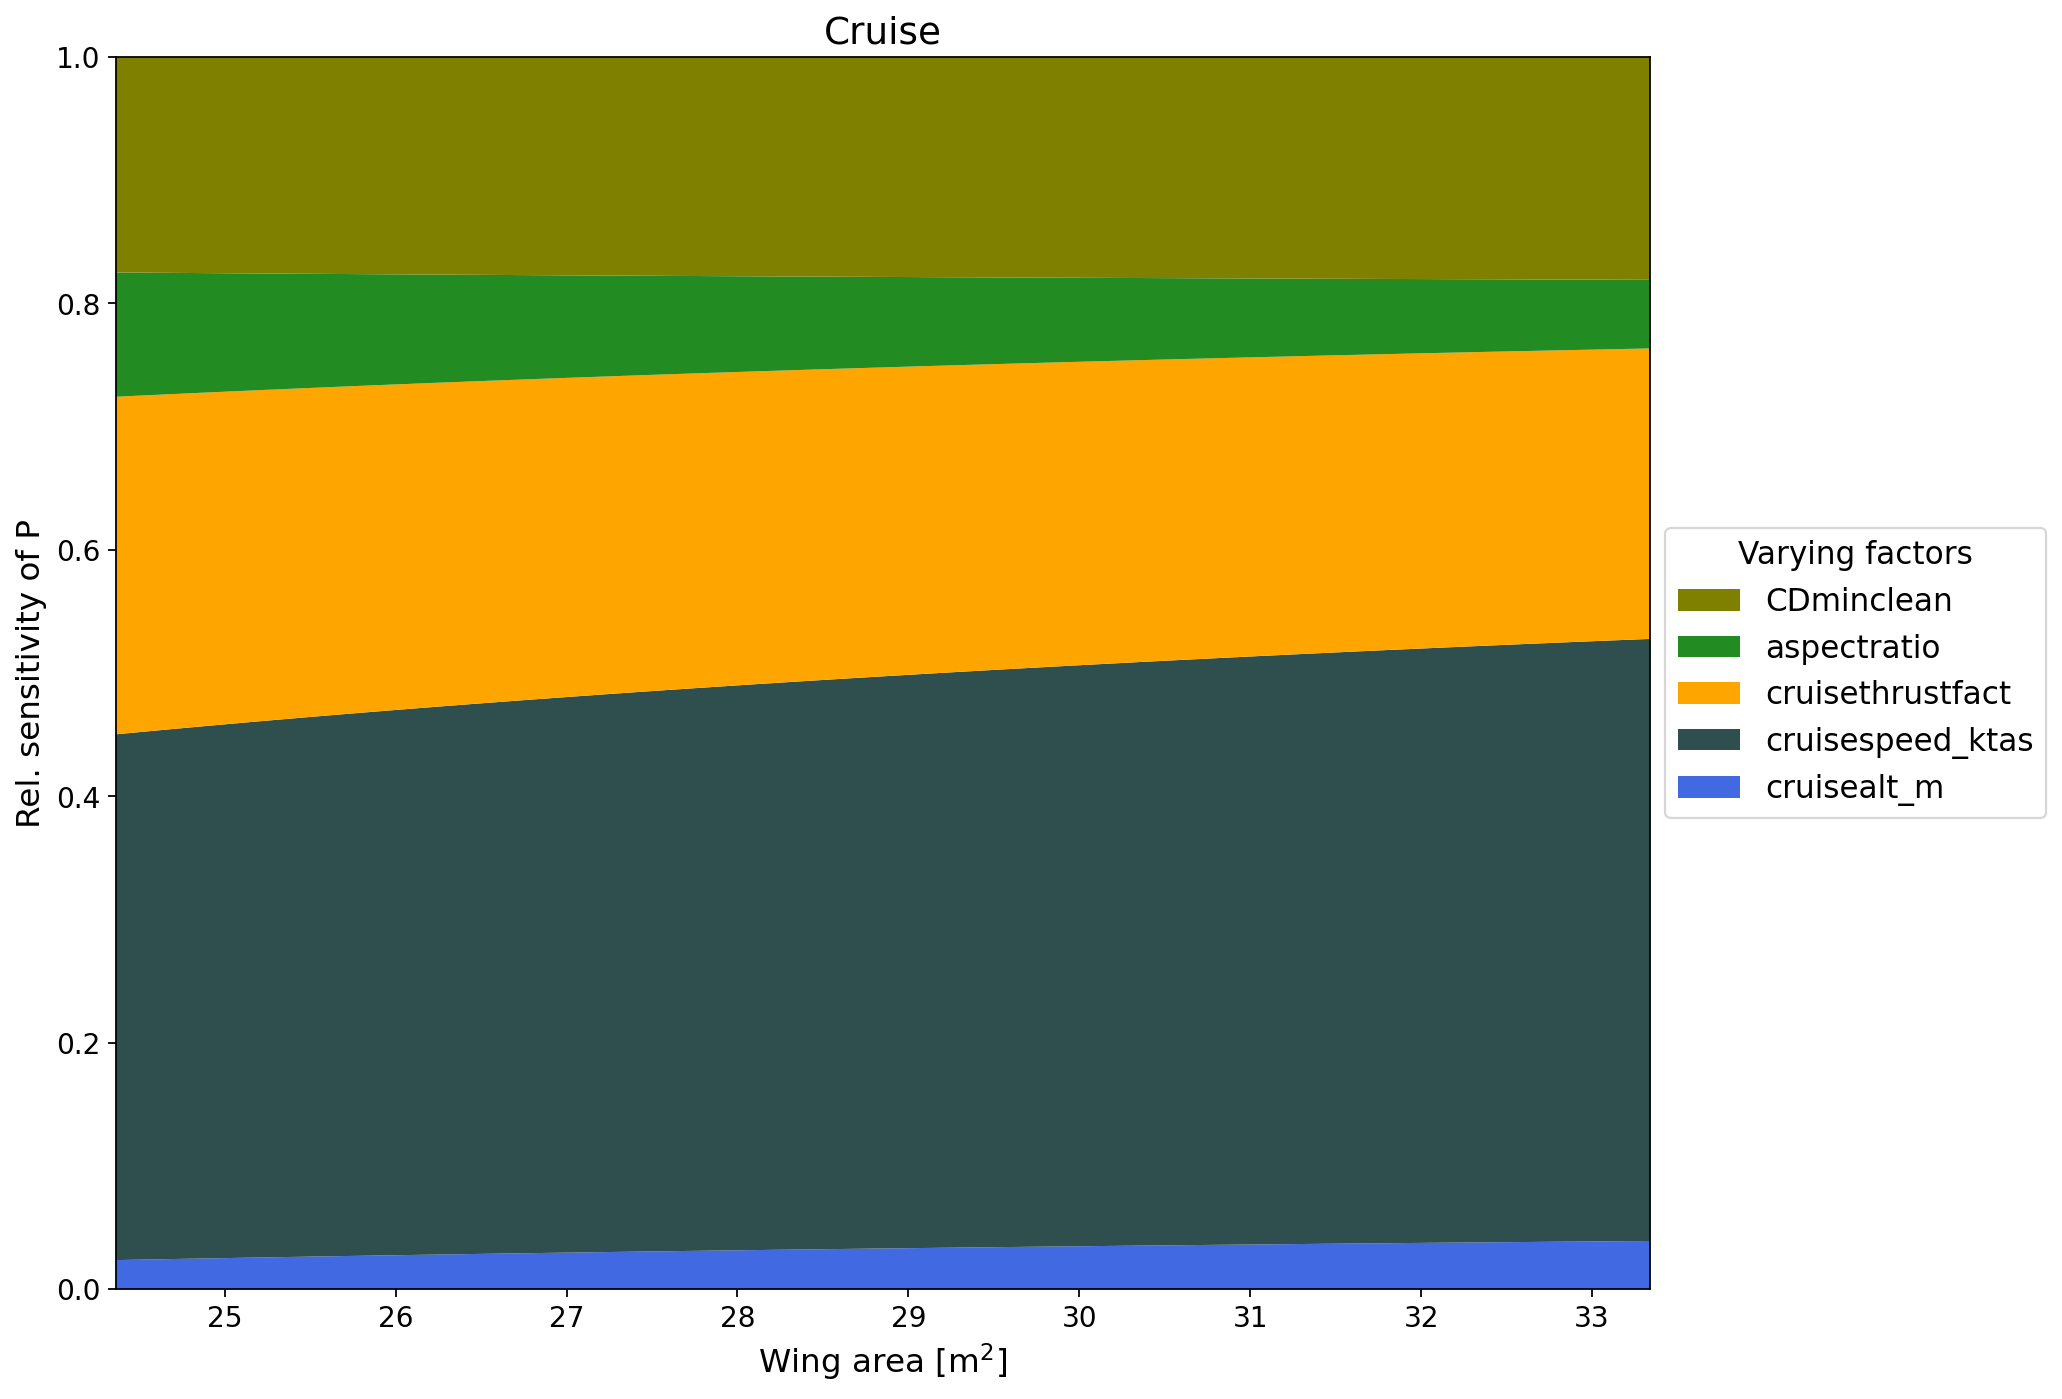

In [7]:
def _span(v, frac=0.05):
    v = float(v)
    if v <= 0.0:
        return v
    return [v * (1.0 - frac), v * (1.0 + frac)]

designbrief_sens = {
    'rwyelevation_m': float(designbrief['rwyelevation_m']),
    'groundrun_m': _span(designbrief['groundrun_m']),
    'stloadfactor': _span(designbrief['stloadfactor']),
    'turnalt_m': _span(designbrief['turnalt_m']),
    'turnspeed_ktas': _span(designbrief['turnspeed_ktas']),
    'climbalt_m': float(designbrief['climbalt_m']),
    'climbspeed_kias': _span(designbrief['climbspeed_kias']),
    'climbrate_fpm': _span(designbrief['climbrate_fpm']),
    'cruisealt_m': _span(designbrief['cruisealt_m']),
    'cruisespeed_ktas': _span(designbrief['cruisespeed_ktas']),
    'cruisethrustfact': _span(designbrief['cruisethrustfact']),
    'servceil_m': _span(designbrief['servceil_m']),
    'secclimbspd_kias': _span(designbrief['secclimbspd_kias']),
    'vstallclean_kcas': _span(designbrief['vstallclean_kcas']),
}

designdefinition_sens = {
    'aspectratio': _span(designdefinition['aspectratio']),
    'sweep_le_deg': designdefinition['sweep_le_deg'],
    'sweep_mt_deg': designdefinition['sweep_mt_deg'],
    'weightfractions': designdefinition['weightfractions'],
    'weight_n': co.kg2n(TOW_kg),
}

designperformance_sens = {
    'CDTO': _span(designperformance['CDTO']),
    'CLTO': _span(designperformance['CLTO']),
    'CLmaxTO': _span(designperformance['CLmaxTO']),
    'CLmaxclean': _span(designperformance['CLmaxclean']),
    'mu_R': designperformance['mu_R'],
    'CDminclean': _span(designperformance['CDminclean']),
    'etaprop': {
        # Keep etaprop scalar for ADRpy compatibility in electric cases.
        'take-off': designperformance['etaprop']['take-off'],
        'climb': designperformance['etaprop']['climb'],
        'cruise': designperformance['etaprop']['cruise'],
        'turn': designperformance['etaprop']['turn'],
        'servceil': designperformance['etaprop']['servceil'],
    },
}

concept_sens = ca.AircraftConcept(
    designbrief_sens,
    designdefinition_sens,
    designperformance_sens,
    designatm,
    designpropulsion,
)

from matplotlib.ticker import FuncFormatter

y_lim_sens_p_hp = float(co.kw2hp(y_lim_power_kw))

def _run_sensitivity_plot_with_kw_labels(show_arg, **kwargs):
    _show_orig = plt.show
    _close_orig = plt.close
    try:
        # Preserve ADRpy styling while allowing post-format axis relabeling.
        plt.show = lambda *args, **kw: None
        plt.close = lambda *args, **kw: None
        concept_sens.propulsionsensitivity_monothetic(
            wingloading_pa=wslist_pa,
            show=show_arg,
            y_var='p_hp',
            x_var='s_m2',
            y_lim=y_lim_sens_p_hp,
            **kwargs,
        )
    finally:
        plt.show = _show_orig
        plt.close = _close_orig
    fig = plt.gcf()
    for ax in fig.axes:
        if ax.get_ylabel().strip() == 'Power required [hp]':
            ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f"{co.hp2kw(y):.0f}"))
            ax.set_ylabel('Power required [kW]')
    plt.show()

_run_sensitivity_plot_with_kw_labels(True)

_run_sensitivity_plot_with_kw_labels('cruise', maskbool=False)
